# Part 1 -  Collecting Data (Tweets from NY)

## Data - PreProcessing

Because we don't have property of gender in tweet structure, we needed to use the NLTK well known names to build our train dataset.

In order to extract as much as possible the correct gender, we filter all the names which can be use for female and for male.

In [3]:
#import nltk
#nltk.download()

from nltk.corpus import names

def GetWellDefineGenderFromName(first_name):
    first_name = first_name.lower()
    first_name = first_name.title()
    matchMale = False
    matchFemale = False
    if first_name in names.words("male.txt"):
        matchMale = True
    if first_name in names.words("female.txt"):
        matchFemale = True
    if matchMale and matchFemale:
        return None
        
    if matchMale:        
        return 'male'
        
    if matchFemale:
        return 'female'        
        
    return None

## Fetch raw data from tweeter

We choose that our population will be people from NY.

In order to get a meaningful tweets (means no commercial tweets from real people),we did the following:

1. Search for the words 'The', 'I', 'she', 'and'.
2. Ensure that the user language is english.
3. Ensure that the user location is NY.
4. Ensure that the name gender is well define as explaind above. 

In [4]:
#!conda install -c conda-forge tweepy=3.5.0
#!conda install -c malev gender_detector=0.1.0

import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import requests
import json

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

class StdOutListener(StreamListener):
    def on_data(self, data):            
        
        tweet = json.loads(data)
        
        if not tweet.get('user'):
            return True
        
        user = tweet['user']    
        
        if user['lang'] != 'en':
            return True
        
        if user['location'] is None:
            return True
        
        if 'New York' not in user['location'] and 'NY' not in user['location']:
            return True
        
        gender = GetWellDefineGenderFromName(user['name'].encode('utf-8').split()[0])
        
        if gender is None:
            return True
        
        # append the hourly tweet file
        with open('tweets.data', 'a+') as f:
            f.write(data)            
        
        return True
    
    def on_error(self, status):
        print('status: %s' % status)

streamListener = StdOutListener()
stream = Stream(auth, streamListener, timeout=30)


####
#call the below function when you want to fetch data
####

stream.filter(locations=[-74,40,-73,41], track=['The', 'I', 'she', 'and'])

NameError: name 'consumer_key' is not defined

## Data Cleaning - Define fucntions

### Decoding text to Ascii

Most of the NL Algorithms works with ASCII.

In [5]:
def UTFToAscii(string):
    return string.decode('ascii', 'ignore')

### Extract URLs, @user_reference, hashtags Count

In [6]:
def ExtractReference(string):
    reference_count = 0
    hashtag_count = 0
    urls_count = 0
    for i in string.split():
        s, n, p, pa, q, f = urlparse.urlparse(i)
        if s and n:
            urls_count = urls_count + 1
        elif i[:1] == '@':
            reference_count = reference_count + 1
        elif i[:1] == '#':
            hashtag_count = hashtag_count + 1            
        else:
            pass
    return reference_count, hashtag_count, urls_count

### Remove URLs, hashtags, @user_reference

In [7]:
import re
import urlparse

def RemoveNonWords(string):
    return re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", string)

### Handle Escaping Characters

In [8]:
import HTMLParser

def RemoveEscaping(string):
    html_parser = HTMLParser.HTMLParser()
    return html_parser.unescape(string)

### Convert to lowercase

In [9]:
def ToLowercase(string):
    return string.lower()

### Handle Apostrophe Lookup

In [10]:
import csv

def ReplaceApostrophe(string):
    appostophes_dict = None

    with open('appostophes.csv', mode='r') as infile:
        reader = csv.reader(infile)
        appostophes_dict = {rows[0]:rows[1] for rows in reader}
    
    words = string.split()
    reformed = [appostophes_dict[word] if word in appostophes_dict else word for word in words]
    string = " ".join(reformed)
    return string
    

### Clean RT

In [11]:
def RemoveRT(string):
    words = string.split()
    reformed = ['' if word in 'RT' else word for word in words]
    string = " ".join(reformed)
    return string

### Flat Lines

In [12]:
def FlatLines(string):
    lines = string.splitlines()
    string = " ".join(lines)
    return string

## Create dataframe from Json tweets file

In [13]:
import pandas as pd
import json

def IsEnglish(s):
    for i in s.split():
        if not i.isalpha():
            return False
    return True    

#read data from tweets.data

tweets_df = pd.DataFrame(columns=['id', 'text', 'reference_count', 'hashtag_count', 'urls_count' ,'name', 'gender'])
for line in open('tweets.data', 'r'):    
    tweet_data = json.loads(line)
    tweet_fullname = tweet_data['user']['name'].encode('utf-8')
    if IsEnglish(tweet_fullname) == False:
        continue

    if len(tweet_fullname.split()) < 2:
        continue

    tweet_text = tweet_data['text'].encode('utf-8')
    tweet_text = UTFToAscii(tweet_text)
    tweet_text = RemoveEscaping(tweet_text)
    tweet_text = FlatLines(tweet_text)
    reference_count, hashtag_count, urls_count = ExtractReference(tweet_text)
    tweet_text = RemoveNonWords(tweet_text)    
    tweet_text = RemoveRT(tweet_text)
    tweet_text = ToLowercase(tweet_text)
    tweet_text = ReplaceApostrophe(tweet_text)

    #filter all text that smaller then 2 words
    if len(tweet_text.split()) < 3:
        continue
    
    #filter all names with no legal capital letter
    if  len(re.findall(r'[A-Z]',tweet_fullname)) != len(tweet_fullname.split()):            
        continue
    
    gender = GetWellDefineGenderFromName(tweet_fullname.split()[0])
    
    if gender is None:
        continue

    tweets_df.loc[len(tweets_df)]=[tweet_data['id_str'], tweet_text, reference_count, hashtag_count, urls_count, tweet_fullname, gender]


## Write Dataframe as CSV File

In [24]:
tweets_df.to_csv('tweets_df.csv')

## Data Exploration

First quick look in the data:

In [15]:
tweets_df.head(10)

,id,text,reference_count,hashtag_count,urls_count,name,gender
0,875088051977977856,how to give your employees the recognition the...,0.0,1.0,1.0,Guy Santeramo,male
1,875088067471831043,that was lovely thank you for sharing i too lo...,3.0,0.0,1.0,Alexa Harrison,female
2,875088072786022400,sling could a team made entirely of players wh...,0.0,0.0,1.0,Jay Zampi,male
3,875088110736089089,my fan theory is that your fan theory has noth...,1.0,0.0,0.0,Susana Polo,female
4,875088135889334273,if you say so princess im sure hell love to se...,1.0,0.0,1.0,Brad Gibson,male
5,875088148770033665,when she asks you what you bring to the table,1.0,0.0,1.0,Solomon Grundy,male
6,875088173939818497,finally biting the bullet and reserving hotel ...,0.0,1.0,0.0,Meg Roy,female
7,875088203258109952,im speaking at digipub summit in new york this...,0.0,2.0,1.0,Adam Smith,male
8,875088215715217410,this couldnt be easier i just called my rep to...,1.0,0.0,0.0,Krystyna Hutchinson,female
9,875088231964041218,the gun contagion in america continues to thre...,1.0,0.0,1.0,Michael Corley,male


The texts are look good and also the names the and the gender.

In [16]:
tweets_df.describe(include='all')

,id,text,reference_count,hashtag_count,urls_count,name,gender
count,4133,4133,4133.000000,4133.000000,4133.000000,4133,4133
unique,4133,3986,NaN,NaN,NaN,3361,2
top,875432697602113537,i just want a country where affording health c...,NaN,NaN,NaN,Joe Dicandia,male
freq,1,8,NaN,NaN,NaN,14,2490
mean,NaN,NaN,1.032664,0.345996,0.533995,NaN,NaN
std,NaN,NaN,0.987407,0.966179,0.571270,NaN,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,1.000000,0.000000,1.000000,NaN,NaN


In [17]:
tweets_df['gender'] = tweets_df['gender'].astype('category')
tweets_df.gender.value_counts()

male      2490
female    1643
Name: gender, dtype: int64

We have 4133 samples.

female: ~0.39
male:~0.61

Types:

In [18]:
tweets_df.dtypes

id                   object
text                 object
reference_count     float64
hashtag_count       float64
urls_count          float64
name                 object
gender             category
dtype: object

Should not be missing values:

In [19]:
tweets_df.isnull().sum()

id                 0
text               0
reference_count    0
hashtag_count      0
urls_count         0
name               0
gender             0
dtype: int64

### Male ,Female Ratio

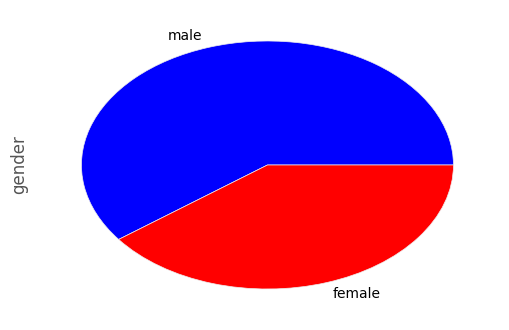

In [20]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

plt.figure();

tweets_df.gender.value_counts().plot(kind='pie', colors=['blue','red'])

## Tweet Reference, Hashtag, URL Count By Gender


Let's explore the information which we extract from the original tweet text.


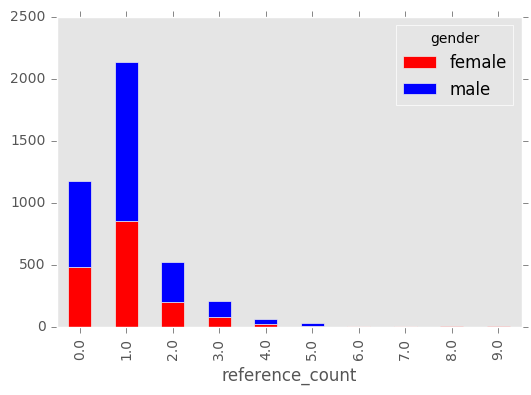

In [21]:
var = pd.crosstab(tweets_df['reference_count'], tweets_df['gender'])
var.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

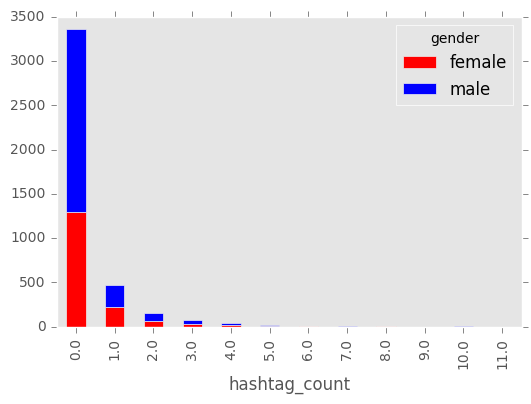

In [22]:
var = pd.crosstab(tweets_df['hashtag_count'], tweets_df['gender'])
var.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

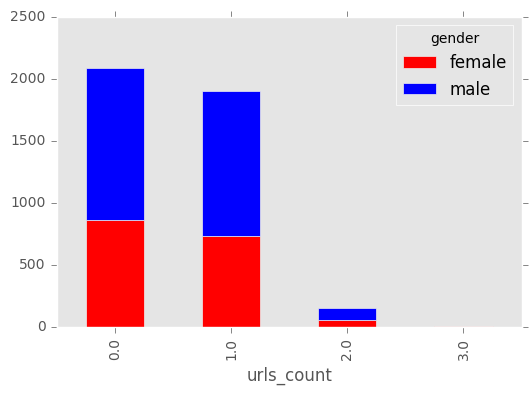

In [23]:
var = pd.crosstab(tweets_df['urls_count'], tweets_df['gender'])
var.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

We can see from above that these features not give us an additional information. (the male/female ratio remains almost the same for each value).

## Backup Dataframe to Pickle file

In [29]:
tweets_df.to_pickle('DataFramePickle')

# Part 2 - Part 2 - Train Classifier For Gender

## Global Configuration

In [62]:
import os

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
write_path = 'Models\\'

ensure_dir(write_path)

## This function returns the top features for every model

In [25]:
def print_topFeatures( classifier,stri,numOfFeatures):
    """Prints features with the highest coefficient values, per class"""
    dfSignificantFeatures = pd.DataFrame()
    class_labels = classifier.classes_
    for i, class_label in enumerate(class_labels):
        if len(class_labels)>2:
            coef = classifier.coef_[i]
        else:
            coef = classifier.feature_log_prob_[i]

        top20 = np.argsort(coef)[-40:]
        toList = (" %s" % (",".join(feature_names[j] for j in top20)))
        list = toList.split(',')
        dfSignificantFeatures[class_label.upper()] = list[::-1]
        
    dfSignificantFeatures.to_csv(write_path +'_best40Features_allWords_'+str(numOfFeatures)+stri+'.csv', mode='a', sep=',')

## This function returns the train and test sets

In [36]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_test_set(df, numOfFeatures, RemoveStopWords, f, t, analyzer):

    corpus = np.array(df.text.values).tolist()
    target = np.array(df['gender'].values)
    #tf-idf vectorizer is set to count word occurances and normalize. NOT TF-IDF
    if RemoveStopWords:
        vectorizer = TfidfVectorizer(stop_words='english',analyzer=analyzer,use_idf=False, ngram_range=(f,t),binary=False)
    else: #only SW
        vectorizer = TfidfVectorizer(max_features=numOfFeatures,analyzer=analyzer, use_idf=False, ngram_range=(f,t),binary=False,norm='l1')
    
    X = vectorizer.fit_transform(corpus)
    global feature_names
    feature_names = vectorizer.get_feature_names()

    return X, target, feature_names#

## This function plots a confusion matrix

In [44]:
def plot_cnf_matrix(cms, classes, model_name, numOfFeatures):
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(cms), cmap=plt.cm.jet, interpolation='nearest')
    
    width, height = cms.shape
    
    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(cms[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    
    cb = fig.colorbar(res)
    plt.xticks(range(width), classes)
    plt.yticks(range(height), classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix " + str(numOfFeatures) + ' ' + model_name)    

## This function helps us to classify our data 

In [68]:
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeClassifier
import pickle
import sklearn.naive_bayes as nb
import sklearn

def Classify(df,RemoveStopWords,analyzer,n):
    a = {'Classifer': pd.Series(index=['DT', 'Naive bayes', 'SVM linear' ]),}
    scoreTable = pd.DataFrame(a)

    scoreTable.__delitem__('Classifer')

    tests = ['allLangs'] 
    nums = [100,200,400,600,900]

    for test in tests:
        dfReduced = df.copy(deep=True)

        if test is not "allLangs":
            langs = str.split(test, '_')
            dfReduced = dfReduced[dfReduced['gender'].isin(langs)]
        
        #if we want to check for several x top featurs
        for numOfFeatures in nums:
            nfolds=5
            accuracies = []
            data, target, feat_names = extract_test_set(dfReduced,numOfFeatures,RemoveStopWords, n,n, analyzer)
            kf = KFold(data.shape[0], n_folds = nfolds, shuffle = True, random_state = 1)
            
            test = test+" top "+str(numOfFeatures)+" features"
            
            dtree = DecisionTreeClassifier(random_state=0, max_depth=50)
            acc = train_model_kf_cv(dtree, kf, data, target, nfolds, 'DT',numOfFeatures)
            accuracies.append(acc)
            pickle.dump(dtree, open(write_path+"dtree"+str(numOfFeatures), 'wb'))

            bayes = nb.MultinomialNB()
            acc = train_model_kf_cv(bayes, kf, data, target, nfolds, 'Naive bayes',numOfFeatures)
            accuracies.append(acc)
            pickle.dump(bayes, open(write_path+"bayes"+str(numOfFeatures), 'wb'))

            print_topFeatures(bayes,'bayes',numOfFeatures)

            clf = sklearn.svm.SVC(decision_function_shape='ovo',kernel='linear')
            acc = train_model_kf_cv(clf, kf, data, target, nfolds, 'SVM linear',numOfFeatures)
            accuracies.append(acc)
            pickle.dump(clf, open(write_path+"svm"+str(numOfFeatures), 'wb'))
            scoreTable[numOfFeatures] = accuracies
    return scoreTable
    #writer = pd.ExcelWriter(write_path  + '_Results.xlsx')
    #scoreTable.to_excel(writer,'Score table')
    #writer.save()

## This function trains the model k-fold times and returns total accuracy

In [67]:
from sklearn.metrics import confusion_matrix

def train_model_kf_cv(model, kf, data, target, numFolds, model_name,numFeatures):
    cm = []
    error = []
    for train_indices, test_indices in kf:
        # Get the dataset; this is the way to access values in a pandas DataFrame
        train_X = data[train_indices, :]
        train_Y = target[train_indices]
        test_X = data[test_indices, :]
        test_Y = target[test_indices]
        # Train the model
        model.fit(train_X, train_Y)
        predictions = model.predict(test_X)
        # Evaluate the model
        ###fpr, tpr, _ = roc_curve(test_Y, predictions)
        classes = model.classes_                
        cm.append(confusion_matrix(test_Y, predictions, labels=classes))
        ###total += auc(fpr, tpr)
        error.append(model.score(test_X, test_Y))
    accuracy = np.mean(error)
    for i in range(0,9):
        cms = np.mean(cm, axis=0)
    plot_cnf_matrix(cms, classes, model_name,numFeatures)
    ###auc = total / numFolds
    ###print "AUC of {0}: {1}".format(Model.__name__, accuracy)
    return accuracy

## Read DataFrame and run Classifier

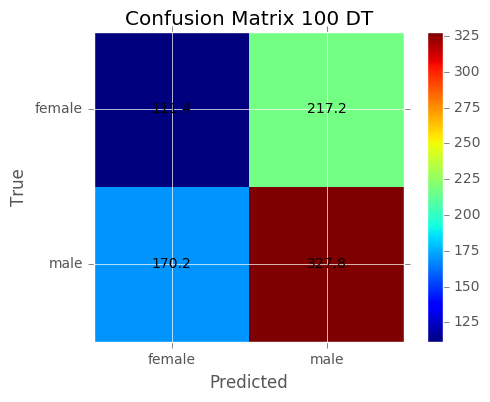

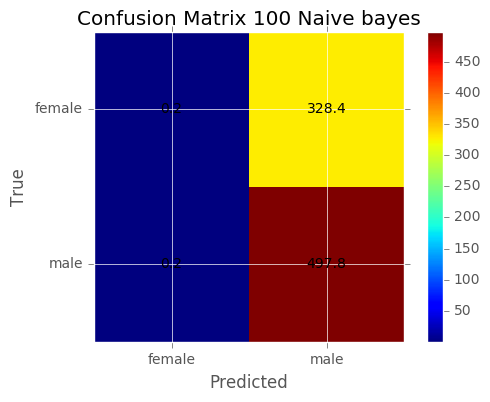

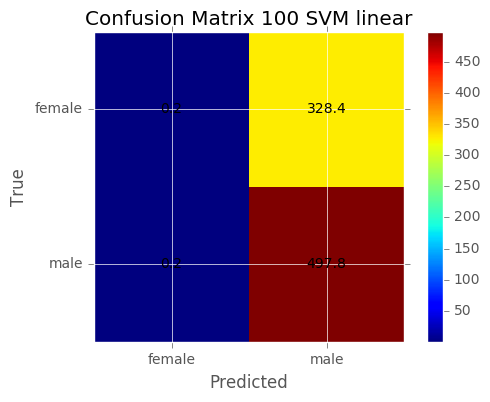

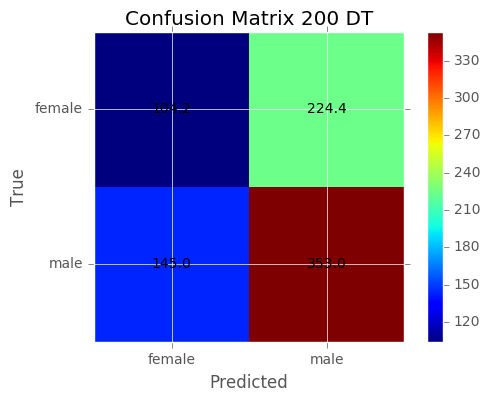

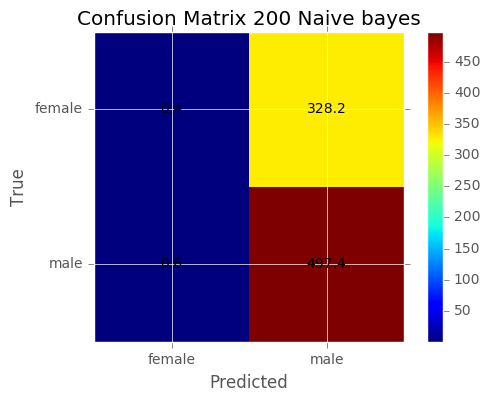

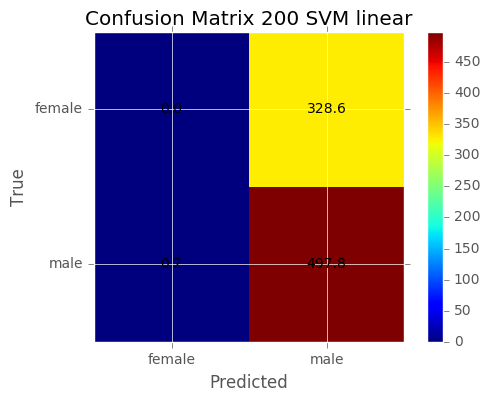

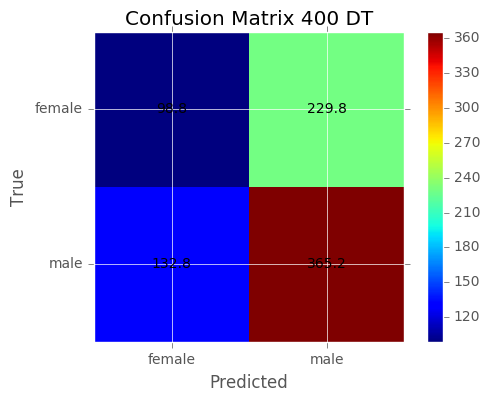

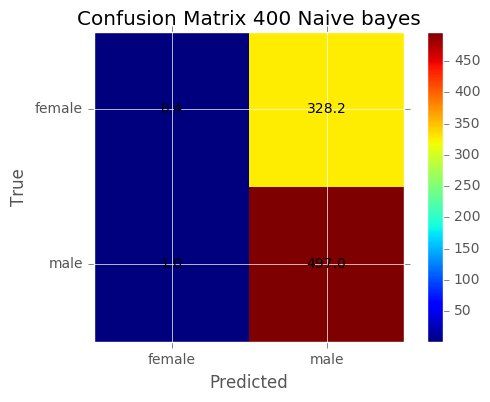

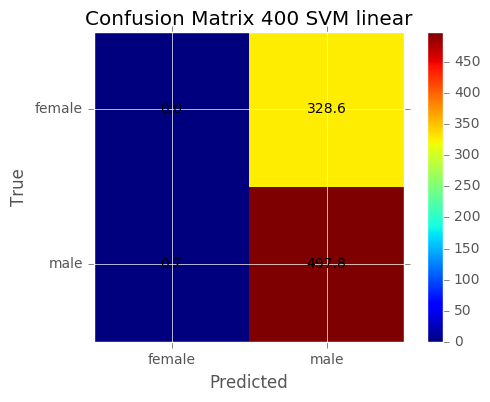

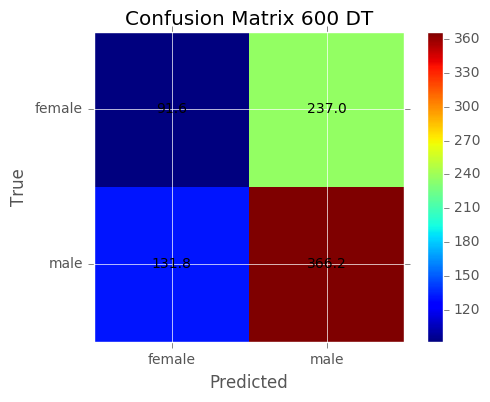

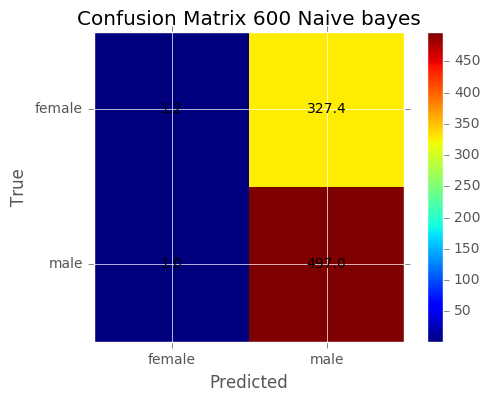

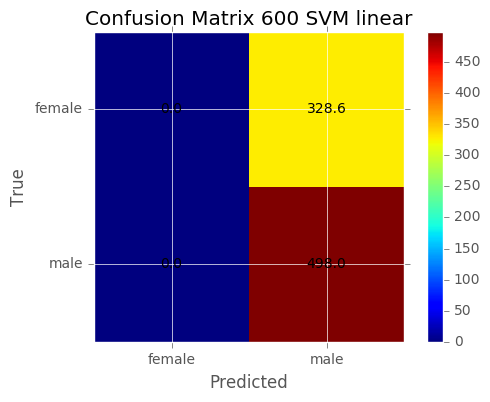

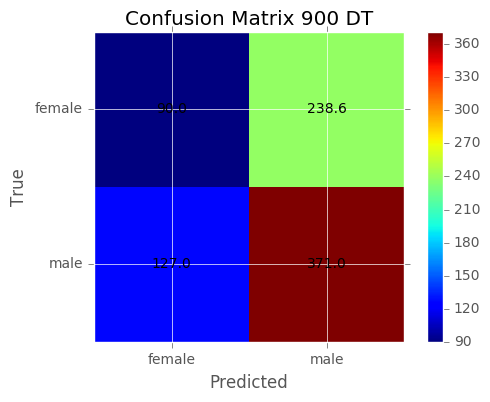

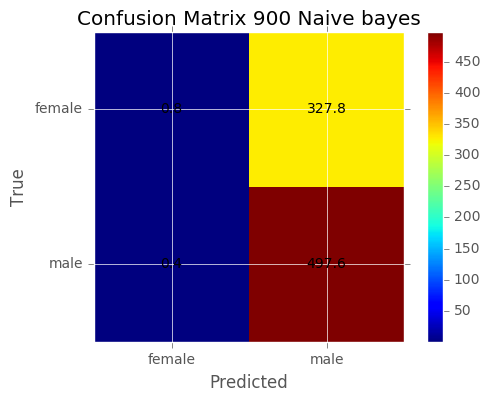

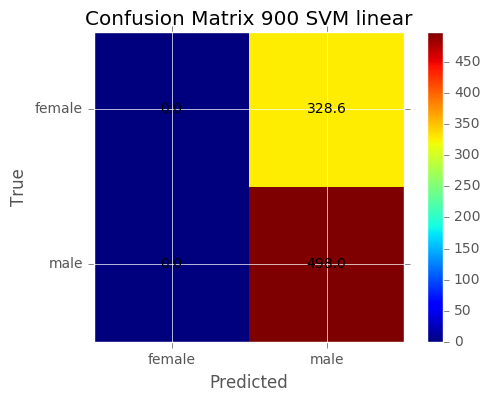

In [69]:
tweets_df = pd.read_pickle(r'DataFramePickle')

scoreTable = Classify(tweets_df, False, 'word', 1)

## Score Table

In [70]:
scoreTable

,100,200,400,600,900
DT,0.531329,0.553107,0.561325,0.553827,0.557702
Naive bayes,0.602465,0.602223,0.601739,0.602707,0.602948
SVM linear,0.602465,0.602223,0.602223,0.602464,0.602464
